# Fit quality visualization notebook

### Installs

In [1]:
# Make sure some required libraries are installed
!pip install --user -q arviz tqdm papermill

### Parameters changed by Papermill

In [2]:
package_path = '.'  # Where our Python package is (directory containing the __init__.py file)
model_path = '.'  # Directory where our .stan files are located 
model_name = 'reducedlinearmodelR0'
roi = 'US_MI'
data_path = "../data"  # Directory containing the .csv data files
fits_path = "./fits"  # Directory containing the fit files
fit_format = 1  # 0: The one using a .csv of the samples; 1: The one pickling the fit instance and some other things

### Imports

In [3]:
import sys
sys.path.insert(0, package_path)  # Make sure our package can be loaded

In [1]:
from __init__ import load_or_compile_stan_model, load_fit, extract_samples
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import pystan
import re
import sys

### Load the model

Loading reducedlinearmodelR0 from cache...


### Load the data

In [6]:
data_path_ = Path(data_path) / ("covidtimeseries_%s.csv" % roi)  # Full path to the data file for this ROI
data = pd.read_csv(data_path_)  # Load the data

### Load the fits and samples

In [7]:
samples = extract_samples(fits_path, model_name, roi, fit_format)

### Choose the parameter list

In [9]:
# List of parameters to visualize as a histogram; log binning is optional
hist_params = ['R0:log=True']

# List of parameters to visualize vs time
time_params = ['car', 'ifr']

In [49]:
def josh_likelihoods(samples):
    log_likelihoods = samples['ll_']    
    n = samples.shape[-1]
    likelihoods = np.exp(log_likelihoods)   # Result is S x N
    lppd = np.sum(np.log(np.mean(likelihoods, axis=0)))
    pwaic = np.sum(np.var(log_likelihoods, axis=0))
    elpdi = np.log(np.mean(likelihoods, axis=0)) - np.var(log_likelihoods, axis=0)
    se = 2*np.sqrt(n*np.var(elpdi))
    return {'waic': 2*(-lppd + pwaic), 'se': se}

#josh_likelihoods(samples)

### Visualize samples (one histogram and color per chain)

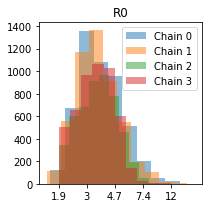

In [10]:
cols = min(len(hist_params),4)
rows = math.ceil(len(hist_params)/4)
fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(3*cols, 3*rows))
chains = samples['chain'].unique()
for i, param in enumerate(hist_params):
    options = {}
    ax = axes.flat[i]
    for chain in chains:
        if ':' in param:
            param, options = param.split(':')
            options = eval("dict(%s)" % options)
        chain_samples = samples[samples['chain']==chain][param]
        if options.get('log', False):
            chain_samples = np.log(chain_samples)
        ax.hist(chain_samples, alpha=0.5, label='Chain %d' % chain)
        if options.get('log', False):
            ax.set_xticks(np.linspace(chain_samples.min(), chain_samples.max(), 5))
            ax.set_xticklabels(['%.2g' % np.exp(x) for x in ax.get_xticks()])
        ax.set_title(param)
    plt.legend()
plt.tight_layout()

### Visualize samples across time

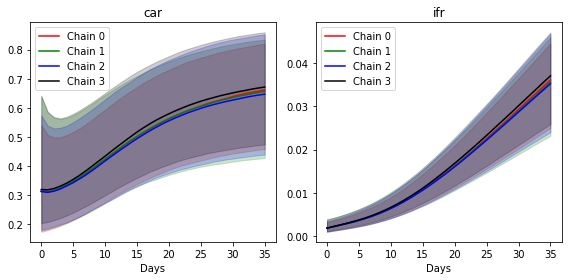

In [11]:
cols = min(len(time_params),4)
rows = math.ceil(len(time_params)/4)
fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(4*cols, 4*rows))
chains = samples['chain'].unique()
colors = 'rgbk'
for i, param in enumerate(time_params):
    options = {}
    ax = axes.flat[i]
    for chain in chains:
        cols = [col for col in samples if param in col]
        chain_samples = samples[samples['chain']==chain][cols]
        quantiles = chain_samples.quantile([0.05, 0.5, 0.95]).T.reset_index(drop=True)
        ax.plot(quantiles.index, quantiles[0.5], label=('Chain %d' % chain), color=colors[chain])
        ax.fill_between(quantiles.index, quantiles[0.05], quantiles[0.95], alpha=0.2, color=colors[chain])
    ax.legend()
    ax.set_title(param)
    ax.set_xlabel('Days')
plt.tight_layout()

### Visualize data and fits

t0 index assumed to be: day 1
t0 date: 03/06/20
tm index assumed to be: day 19
mitigation date: 03/24/20


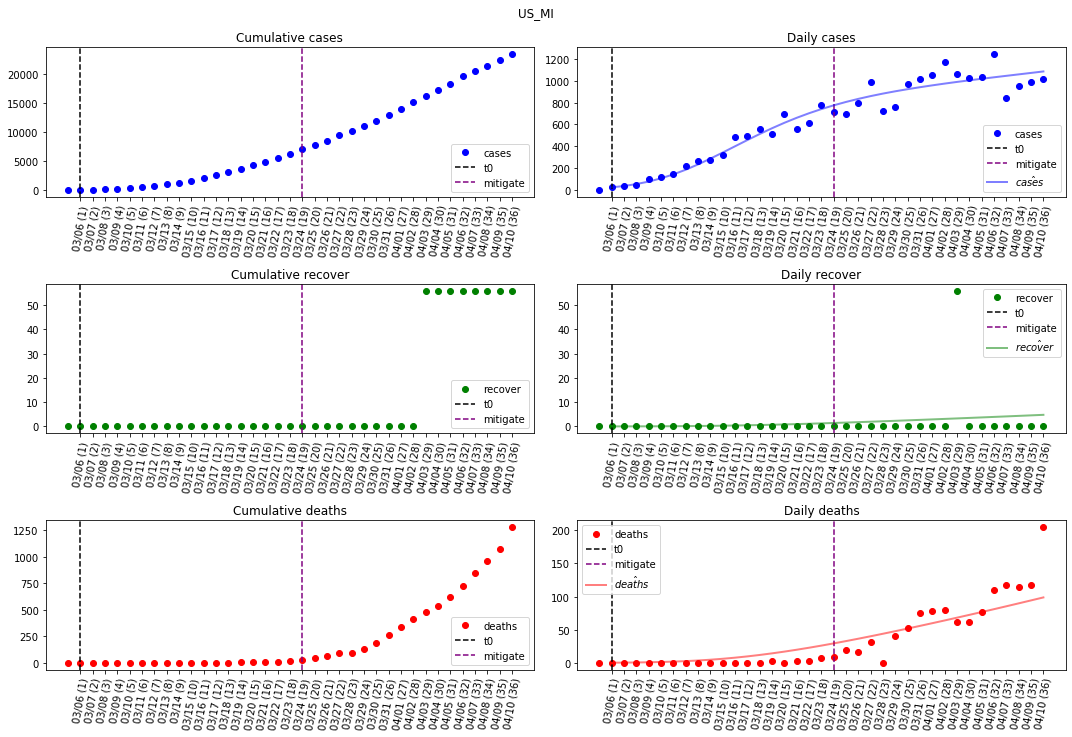

In [32]:
t0 = np.where(data["new_cases"].values>=1)[0][0] 
try:
    dfm = pd.read_csv(Path(data_path) / 'mitigationprior.csv')
    tmdate = dfm.loc[dfm.region==roi, 'date'].values[0]
    tm = np.where(data["dates2"]==tmdate)[0][0]
except:
    print("No mitigation data found; falling back to default value")
    tm = t0 + 10
days, day_labels = zip(*data['dates2'][t0:].apply(lambda x:x[:-3]).iteritems())
day_labels = ['%s (%d)' % (day_labels[i], days[i]) for i in range(len(days))]

def plot_data_and_fits(data, roi, samples, days, t0, tm):
    fig, ax = plt.subplots(3, 2, figsize=(15, 10))

    estimates = {}
    for chain in chains:
        chain_samples = samples[samples['chain']==chain]
        estimates['cases'] = [chain_samples['lambda[%d,0]' % (day-t0)].mean() for day in days]
        estimates['recover'] = [chain_samples['lambda[%d,1]' % (day-t0)].mean() for day in days]
        estimates['deaths'] = [chain_samples['lambda[%d,2]' % (day-t0)].mean() for day in days]

    for i, kind in enumerate(['cases', 'recover', 'deaths']):
        colors = 'bgr'
        ax[i, 0].set_title('Cumulative %s' % kind)
        ax[i, 0].plot(data["cum_%s" % kind],'bo', color=colors[i], label=kind)
        ax[i, 0].axvline(t0, color='k', linestyle="dashed", label='t0')
        ax[i, 0].axvline(tm, color='purple', linestyle="dashed", label='mitigate')
        ax[i, 0].set_xticks(days)
        ax[i, 0].set_xticklabels(day_labels, rotation=80)
        ax[i, 0].legend()

        ax[i, 1].set_title('Daily %s' % kind)
        ax[i, 1].plot(data["new_%s" % kind], 'bo', color=colors[i], label=kind)
        ax[i, 1].axvline(t0, color='k', linestyle="dashed", label='t0')
        ax[i, 1].axvline(tm, color='purple', linestyle="dashed", label='mitigate')
        ax[i, 1].set_xticks(days)
        ax[i, 1].set_xticklabels(day_labels, rotation=80)
        if kind in estimates:
            ax[i, 1].plot(days, estimates[kind], label=r'$\hat{%s}$'% kind, linewidth=2, alpha=0.5, color=colors[i])
        ax[i, 1].legend()

    plt.tight_layout()
    fig.suptitle(roi, y=1.02)
    
lambdas_found = ['lambda[%d,0]' % (day-t0) in list(samples) for day in days]
if all(lambdas_found):
    plot_data_and_fits(data, roi, samples, days, t0, tm)
else:
    print("Could not find days %s in fits" % (pd.Series(days)[lambdas_found].values))
    
print("t0 index assumed to be: day "+str(t0))
print("t0 date: "+data['dates2'][t0])
print("tm index assumed to be: day "+str(tm))
try:
    print("mitigation date: "+data['dates2'][tm])
except:
    print("No mitigation data could be computed")

In [2]:
#import arviz

In [3]:
#arviz.waic(fit)